In [244]:
!pip install rasterio

In [245]:
# Import all the important libraries

import rasterio
from rasterio.plot import show
from rasterio import plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

from sklearn import cluster
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

import tensorflow as tf

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from scipy.stats import chisquare

import tensorflow as tf
from tensorflow import keras

from sklearn.externals import joblib

#**Load Data and Labels**


In [246]:
#Load Labeled Image using Rasterio
dataset = rasterio.open('/content/rasterize_on_sentinel_2_labelled_17SLD.tif')
labeled_image = dataset.read(masked = True)
labeled_image_plot = dataset.read()

In [247]:
#Segregate data into X and y
X = labeled_image[1]
y = labeled_image[0]

mask_X = labeled_image[1].mask
mask_y = labeled_image[0].mask

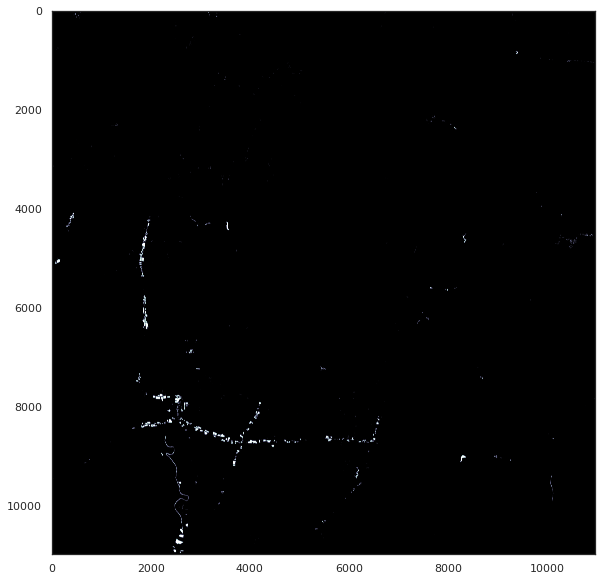

In [248]:
#Plot given class labels of the data
plt.figure(figsize=[10,10])
sns.set_theme(style="white")
plt.imshow(labeled_image_plot[0], cmap='bone_r')
plt.show()

In [249]:
# Observe the shape of X and y
print("Shape of X : ",X.shape)
print("Shape of y : ",y.shape)
print("Shape of Mask of X : ",mask_X.shape)
print("Shape of Mask of y : ",mask_y.shape)

Shape of X :  (10980, 10980)
Shape of y :  (10980, 10980)
Shape of Mask of X :  (10980, 10980)
Shape of Mask of y :  (10980, 10980)


In [250]:
# Observe unique values of X and y
print("Unique Values of X : ",np.unique(X))
print("Unique Values of y : ",np.unique(y))
print("Unique Values of Mask of X : ",np.unique(mask_X))
print("Unique Values of Mask of y : ",np.unique(mask_y))

Unique Values of X :  [154560 154561 154679 ... 563954 563956 --]
Unique Values of y :  [0 1 2 3 4 5 6 --]
Unique Values of Mask of X :  [False  True]
Unique Values of Mask of y :  [False  True]


In [251]:
#Flatten the data
X = X.compressed().reshape(-1,1)
y = y.compressed()

In [252]:
#Shuffle the data
X, y = sklearn.utils.shuffle(X, y, random_state=42)

In [253]:
print("Shape of X : ",X.shape)
print("Shape of y : ",y.shape)
print("Unique Values of X : ",np.unique(X))
print("Unique Values of y : ",np.unique(y))
print("Max Value of X : ",np.max(X))
print("Max Value of y : ",np.max(y))

Shape of X :  (326391, 1)
Shape of y :  (326391,)
Unique Values of X :  [154560 154561 154679 ... 563953 563954 563956]
Unique Values of y :  [0 1 2 3 4 5 6]
Max Value of X :  563956
Max Value of y :  6


In [254]:
#Normalize the input data
X = ( (X - np.min(X)) / (np.max(X) - np.min(X)) )

In [255]:
#Observe normalized data
print("Shape of X : ",X.shape)
print("Shape of y : ",y.shape)
print("Unique Values of X : ",np.unique(X))
print("Unique Values of y : ",np.unique(y))
print("Max Value of X : ",np.max(X))
print("Max Value of y : ",np.max(y))

Shape of X :  (326391, 1)
Shape of y :  (326391,)
Unique Values of X :  [0.00000000e+00 2.44262279e-06 2.90672112e-04 ... 9.99992672e-01
 9.99995115e-01 1.00000000e+00]
Unique Values of y :  [0 1 2 3 4 5 6]
Max Value of X :  1.0
Max Value of y :  6


## **Class Label Distribution**

Find class label distribution in the labeled image

In [256]:
labels, counts = np.unique(labeled_image[0], return_counts= True)

In [257]:
labels, counts = np.unique(y, return_counts= True)

In [258]:
labels

array([0, 1, 2, 3, 4, 5, 6], dtype=uint32)

In [259]:
label_name = ['Urban','Treerow', 'Forest', 'Single Tree', 'Agriculture', 'Grassland', 'Water']

In [260]:
counts

array([ 19088,   7188, 153017,    166,  93879,   7566,  45487])

In [261]:
dist = (counts / sum(counts)) * 100
dist = np.round(dist, 2)

In [262]:
#Create a dataframe of Labels and Distributions
df = pd.DataFrame(list(zip(labels, label_name ,counts, dist)) , columns = ['Label Numbers', 'Label Names','Counts', 'Distribution Percantage'])

In [263]:
df

,Label Numbers,Label Names,Counts,Distribution Percantage
0,0,Urban,19088,5.85
1,1,Treerow,7188,2.20
2,2,Forest,153017,46.88
3,3,Single Tree,166,0.05
4,4,Agriculture,93879,28.76
5,5,Grassland,7566,2.32
6,6,Water,45487,13.94


Text(0.5, 1.0, 'Label Distribution Plot')

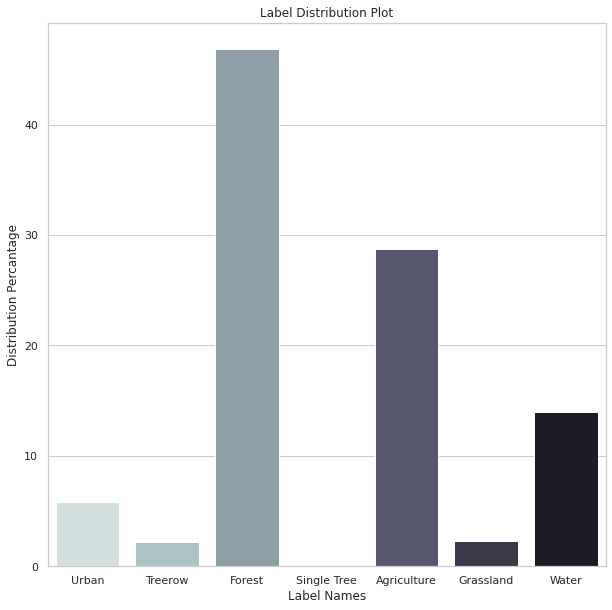

In [264]:
#Observe the Class label distributions
plt.figure(figsize=[10,10])
sns.set_theme(style="whitegrid")
sns.barplot(x='Label Names', y='Distribution Percantage', data=df, palette="bone_r").set_title("Label Distribution Plot")

## **Classifier Creation and Training**

We will be training multiple classifiers and eventually deciding the classifier to use for S-2 bands label predictions

In [265]:
#Create 4 classifiers
LC = LogisticRegression()
DT = DecisionTreeClassifier(max_depth=2)
RF = RandomForestClassifier(max_depth=2)
SVC = LinearSVC(dual = False)

In [266]:
#Fit the classifiers
LC.fit(X,y)
DT.fit(X,y)
RF.fit(X,y)
SVC.fit(X,y)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [267]:
#FInd predictions
preds_LC = LC.predict(X)
preds_DT = DT.predict(X)
preds_RF = RF.predict(X)
preds_SVC = SVC.predict(X)

In [268]:
#Create a Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(7)
])

In [269]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [270]:
history = model.fit(X, y, epochs=5)

Epoch 1/5
10200/10200 [==============================] - 21s 2ms/step - loss: 0.1518 - accuracy: 0.9468
Epoch 2/5
10200/10200 [==============================] - 21s 2ms/step - loss: 0.0041 - accuracy: 0.9991
Epoch 3/5
10200/10200 [==============================] - 22s 2ms/step - loss: 0.0029 - accuracy: 0.9992
Epoch 4/5
10200/10200 [==============================] - 21s 2ms/step - loss: 0.0032 - accuracy: 0.9993
Epoch 5/5
10200/10200 [==============================] - 21s 2ms/step - loss: 0.0022 - accuracy: 0.9996


In [271]:
NN_loss, NN_accuracy = model.evaluate(X, y, verbose = 1)

10200/10200 [==============================] - 16s 2ms/step - loss: 4.4023e-04 - accuracy: 1.0000


In [272]:
probability_model = tf.keras.Sequential([model,
                             tf.keras.layers.Softmax()])

In [273]:
#Find predictions from NN
preds_NN = np.argmax(probability_model.predict(X, batch_size=64), axis=-1)

In [274]:
preds_NN

array([2, 4, 3, ..., 2, 4, 2])

# **Evaluation of the Classifiers**


We will use Accuracy , Precision , Recall and Confusion Matrix to evaluate the Classifiers

**Accuracy Score :**

In [275]:
LC_accuracy = accuracy_score(preds_LC, y)
DT_accuracy = accuracy_score(preds_DT, y)
RF_accuracy = accuracy_score(preds_RF, y)
SVC_accuracy = accuracy_score(preds_SVC, y)

print("Linear Classifier Accuracy         : ", np.round(LC_accuracy,3))
print("Support Vector Classifier Accuracy : ", np.round(SVC_accuracy,3))
print("Neural Network Accuracy            : ", np.round(NN_accuracy,3))
print("Decision Tree Classifier Accuracy  : ", np.round(DT_accuracy,3))
print("Random Forest Classifier Accuracy  : ", np.round(RF_accuracy,3))

Linear Classifier Accuracy         :  0.617
Support Vector Classifier Accuracy :  0.815
Neural Network Accuracy            :  1.0
Decision Tree Classifier Accuracy  :  0.896
Random Forest Classifier Accuracy  :  0.896


**Precision Score:**

In [276]:
LC_precision = precision_score(preds_LC, y, average = 'micro')
DT_precision = precision_score(preds_DT, y, average = 'micro')
RF_precision = precision_score(preds_RF, y, average = 'micro')
SVC_precision = precision_score(preds_SVC, y, average = 'micro')
NN_precision = precision_score(preds_NN, y, average = 'micro')

print("Linear Classifier Precision Score         : ", np.round(LC_precision,3))
print("Support Vector Classifier Precision Score : ", np.round(SVC_precision,3))
print("Neural Network Precision Score            : ", np.round(NN_precision,3))
print("Decision Tree Classifier Precision Score  : ", np.round(DT_precision,3))
print("Random Forest Classifier Precision Score  : ", np.round(RF_precision,3))

Linear Classifier Precision Score         :  0.617
Support Vector Classifier Precision Score :  0.815
Neural Network Precision Score            :  1.0
Decision Tree Classifier Precision Score  :  0.896
Random Forest Classifier Precision Score  :  0.896


**Recall Score :**

In [277]:
LC_recall = recall_score(preds_LC, y, average = 'micro')
DT_recall = recall_score(preds_DT, y, average = 'micro')
RF_recall = recall_score(preds_RF, y, average = 'micro')
SVC_recall = recall_score(preds_SVC, y, average = 'micro')
NN_recall = recall_score(preds_NN, y, average = 'micro')

print("Linear Classifier Recall Score         : ", np.round(LC_recall,3))
print("Support Vector Classifier Recall Score : ", np.round(SVC_recall,3))
print("Neural Network Recall Score            : ", np.round(NN_recall,3))
print("Decision Tree Classifier Recall Score  : ", np.round(DT_recall,3))
print("Random Forest Classifier Recall Score  : ", np.round(RF_recall,3))

Linear Classifier Recall Score         :  0.617
Support Vector Classifier Recall Score :  0.815
Neural Network Recall Score            :  1.0
Decision Tree Classifier Recall Score  :  0.896
Random Forest Classifier Recall Score  :  0.896


**Confusion Matrix :**

[Text(0, 0.5, 'Urban'),
 Text(0, 1.5, 'Treerow'),
 Text(0, 2.5, 'Forest'),
 Text(0, 3.5, 'Single Tree'),
 Text(0, 4.5, 'Agriculture'),
 Text(0, 5.5, 'Grassland'),
 Text(0, 6.5, 'Water')]

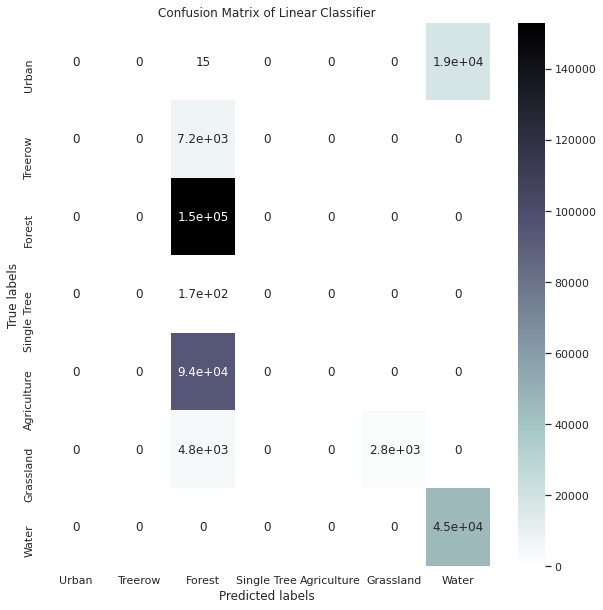

In [278]:
cm = confusion_matrix(y, preds_LC)

plt.figure(figsize=[10,10])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap = 'bone_r') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of Linear Classifier')
ax.xaxis.set_ticklabels(df['Label Names'])
ax.yaxis.set_ticklabels(df['Label Names'])

[Text(0, 0.5, 'Urban'),
 Text(0, 1.5, 'Treerow'),
 Text(0, 2.5, 'Forest'),
 Text(0, 3.5, 'Single Tree'),
 Text(0, 4.5, 'Agriculture'),
 Text(0, 5.5, 'Grassland'),
 Text(0, 6.5, 'Water')]

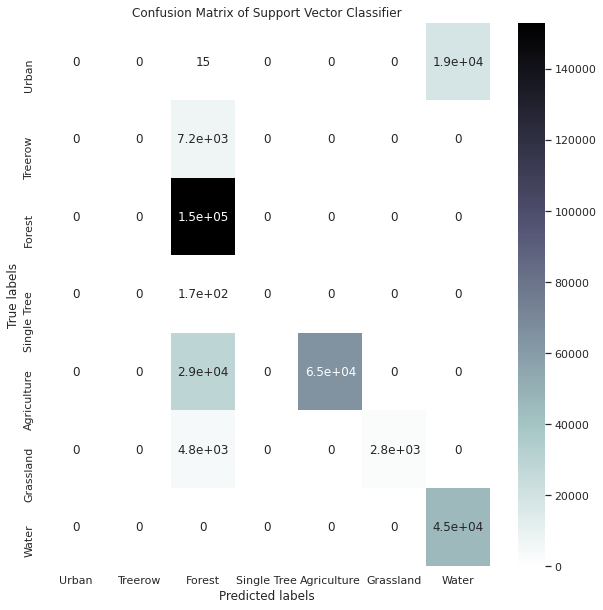

In [279]:
cm = confusion_matrix(y, preds_SVC)

plt.figure(figsize=[10,10])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap = 'bone_r') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of Support Vector Classifier')
ax.xaxis.set_ticklabels(df['Label Names'])
ax.yaxis.set_ticklabels(df['Label Names'])

[Text(0, 0.5, 'Urban'),
 Text(0, 1.5, 'Treerow'),
 Text(0, 2.5, 'Forest'),
 Text(0, 3.5, 'Single Tree'),
 Text(0, 4.5, 'Agriculture'),
 Text(0, 5.5, 'Grassland'),
 Text(0, 6.5, 'Water')]

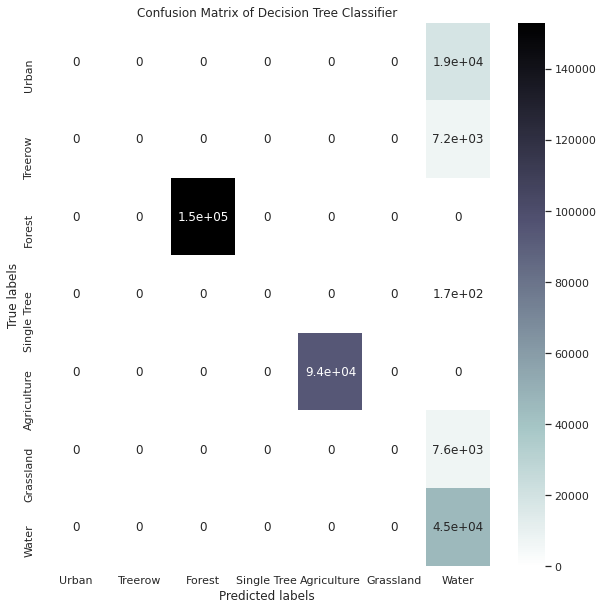

In [280]:
cm = confusion_matrix(y, preds_DT)

plt.figure(figsize=[10,10])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap = 'bone_r') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of Decision Tree Classifier')
ax.xaxis.set_ticklabels(df['Label Names'])
ax.yaxis.set_ticklabels(df['Label Names'])

[Text(0, 0.5, 'Urban'),
 Text(0, 1.5, 'Treerow'),
 Text(0, 2.5, 'Forest'),
 Text(0, 3.5, 'Single Tree'),
 Text(0, 4.5, 'Agriculture'),
 Text(0, 5.5, 'Grassland'),
 Text(0, 6.5, 'Water')]

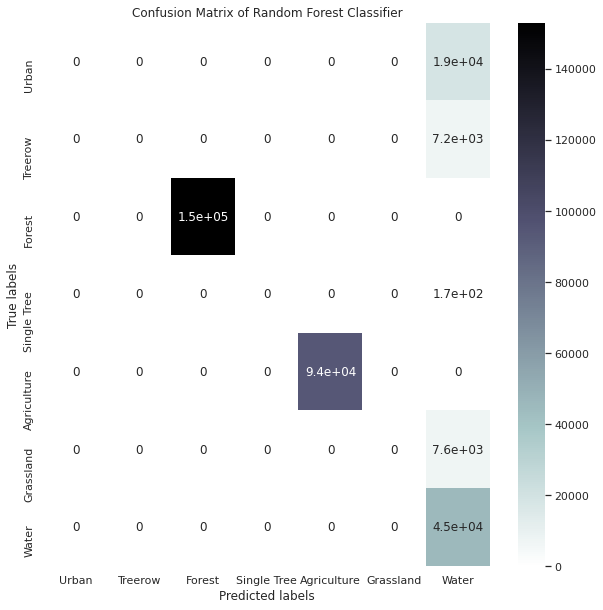

In [281]:
cm = confusion_matrix(y, preds_RF)

plt.figure(figsize=[10,10])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap = 'bone_r') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of Random Forest Classifier')
ax.xaxis.set_ticklabels(df['Label Names'])
ax.yaxis.set_ticklabels(df['Label Names'])

[Text(0, 0.5, 'Urban'),
 Text(0, 1.5, 'Treerow'),
 Text(0, 2.5, 'Forest'),
 Text(0, 3.5, 'Single Tree'),
 Text(0, 4.5, 'Agriculture'),
 Text(0, 5.5, 'Grassland'),
 Text(0, 6.5, 'Water')]

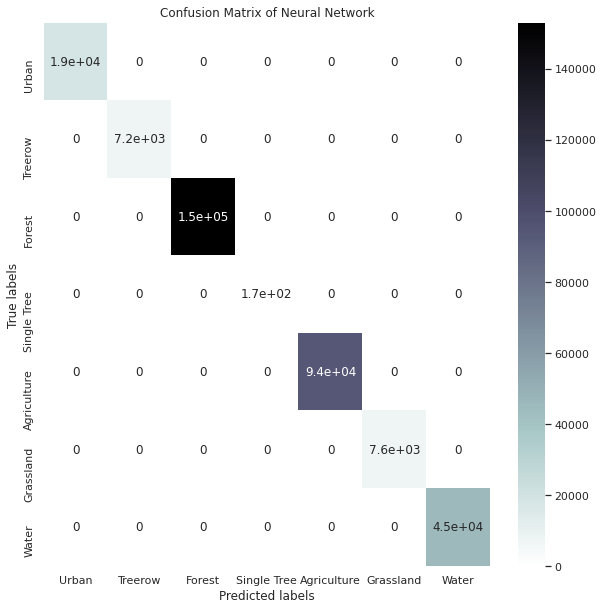

In [282]:
cm = confusion_matrix(y, preds_NN)

plt.figure(figsize=[10,10])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap = 'bone_r') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of Neural Network')
ax.xaxis.set_ticklabels(df['Label Names'])
ax.yaxis.set_ticklabels(df['Label Names'])

# **Save Machine Learning Models :**

In [283]:
#Save all the Machine Learning classifiers(commented right now)
LC_model_name = "/content/LC_model.pkl"
#joblib.dump(LC, LC_model_name)

DT_model_name = "/content/DT_model.pkl"
#joblib.dump(DT, DT_model_name)

RF_model_name = "/content/RF_model.pkl"
#joblib.dump(RF, RF_model_name)

SVC_model_name = "/content/SVC_model.pkl"
#joblib.dump(SVC, SVC_model_name)

In [284]:
#Save the Neural Network Classifier
#model.save('/content/NN_model') 

## **Class Distributions in S-2 Bands**

We will work with all the S-2 bands and predict class labels for each band to visualize which band contains which class labels.

We will be using Support Vector Classifier here.


In [285]:
#Load all the 12 S-2 bands
dataset1 = rasterio.open('/content/Bands/T17SLD_20190922T203454_AOT_10m.tif')
band_AOT_10m = dataset1.read(masked=True).reshape(10980,10980).compressed().reshape(-1,1)
dataset2 = rasterio.open('/content/Bands/T17SLD_20190922T203454_B01_60m.tif')
band_B01_60m = dataset2.read(masked=True).reshape(10980,10980).compressed().reshape(-1,1)
dataset3 = rasterio.open('/content/Bands/T17SLD_20190922T203454_B02_10m.tif')
band_B02_10m = dataset3.read(masked=True).reshape(10980,10980).compressed().reshape(-1,1)
dataset4 = rasterio.open('/content/Bands/T17SLD_20190922T203454_B03_10m.tif')
band_B03_10m = dataset4.read(masked=True).reshape(10980,10980).compressed().reshape(-1,1)
dataset5 = rasterio.open('/content/Bands/T17SLD_20190922T203454_B04_10m.tif')
band_B04_10m = dataset5.read(masked=True).reshape(10980,10980).compressed().reshape(-1,1)

dataset6 = rasterio.open('/content/Bands/T17SLD_20190922T203454_B05_20m.tif')
band_B05_20m = dataset6.read(masked=True).reshape(10980,10980).compressed().reshape(-1,1)
dataset7 = rasterio.open('/content/Bands/T17SLD_20190922T203454_B06_20m.tif')
band_B06_20m = dataset7.read(masked=True).reshape(10980,10980).compressed().reshape(-1,1)
dataset8 = rasterio.open('/content/Bands/T17SLD_20190922T203454_B07_20m.tif')
band_B07_20m = dataset8.read(masked=True).reshape(10980,10980).compressed().reshape(-1,1)
dataset9 = rasterio.open('/content/Bands/T17SLD_20190922T203454_B08_10m.tif')
band_B08_10m = dataset9.read(masked=True).reshape(10980,10980).compressed().reshape(-1,1)
dataset10 = rasterio.open('/content/Bands/T17SLD_20190922T203454_B09_60m.tif')
band_B09_60m = dataset10.read(masked=True).reshape(10980,10980).compressed().reshape(-1,1)

dataset11 = rasterio.open('/content/Bands/T17SLD_20190922T203454_B11_20m.tif')
band_B11_20m = dataset11.read(masked=True).reshape(10980,10980).compressed().reshape(-1,1)
dataset12 = rasterio.open('/content/Bands/T17SLD_20190922T203454_B12_20m.tif')
band_B12_20m = dataset12.read(masked=True).reshape(10980,10980).compressed().reshape(-1,1)
dataset13 = rasterio.open('/content/Bands/T17SLD_20190922T203454_B8A_20m.tif')
band_B8A_20m = dataset13.read(masked=True).reshape(10980,10980).compressed().reshape(-1,1)
dataset14 = rasterio.open('/content/Bands/T17SLD_20190922T203454_SCL_20m.tif')
band_SCL_20m = dataset14.read(masked=True).reshape(10980,10980).compressed().reshape(-1,1)
dataset15 = rasterio.open('/content/Bands/T17SLD_20190922T203454_WVP_10m.tif')
band_WVP_10m = dataset15.read(masked=True).reshape(10980,10980).compressed().reshape(-1,1)

In [286]:
#Observe shapes of data of all bands
print(band_AOT_10m.shape)
print(band_B01_60m.shape)
print(band_B02_10m.shape)
print(band_B03_10m.shape)
print(band_B04_10m.shape)
print(band_B05_20m.shape)
print(band_B06_20m.shape)
print(band_B07_20m.shape)
print(band_B08_10m.shape)
print(band_B09_60m.shape)
print(band_B11_20m.shape)
print(band_B12_20m.shape)
print(band_B8A_20m.shape)
print(band_SCL_20m.shape)
print(band_WVP_10m.shape)

(370243, 1)
(605988, 1)
(370243, 1)
(370243, 1)
(370243, 1)
(415360, 1)
(415360, 1)
(415360, 1)
(370243, 1)
(605988, 1)
(415360, 1)
(415360, 1)
(415360, 1)
(415360, 1)
(370243, 1)


In [287]:
#Normalize all bands data
band_AOT_10m = ((band_AOT_10m-np.min(band_AOT_10m))/(np.max(band_AOT_10m)-np.min(band_AOT_10m)))
band_B01_60m = ((band_B01_60m-np.min(band_B01_60m))/(np.max(band_B01_60m)-np.min(band_B01_60m)))
band_B02_10m = ((band_B02_10m-np.min(band_B02_10m))/(np.max(band_B02_10m)-np.min(band_B02_10m)))
band_B03_10m = ((band_B03_10m-np.min(band_B03_10m))/(np.max(band_B03_10m)-np.min(band_B03_10m)))
band_B04_10m = ((band_B04_10m-np.min(band_B04_10m))/(np.max(band_B04_10m)-np.min(band_B04_10m)))
band_B05_20m = ((band_B05_20m-np.min(band_B05_20m))/(np.max(band_B05_20m)-np.min(band_B05_20m)))
band_B06_20m = ((band_B06_20m-np.min(band_B06_20m))/(np.max(band_B06_20m)-np.min(band_B06_20m)))
band_B07_20m = ((band_B07_20m-np.min(band_B07_20m))/(np.max(band_B07_20m)-np.min(band_B07_20m)))
band_B08_10m = ((band_B08_10m-np.min(band_B08_10m))/(np.max(band_B08_10m)-np.min(band_B08_10m)))
band_B09_60m = ((band_B09_60m-np.min(band_B09_60m))/(np.max(band_B09_60m)-np.min(band_B09_60m)))
band_B11_20m = ((band_B11_20m-np.min(band_B11_20m))/(np.max(band_B11_20m)-np.min(band_B11_20m)))
band_B12_20m = ((band_B12_20m-np.min(band_B12_20m))/(np.max(band_B12_20m)-np.min(band_B12_20m)))
band_B8A_20m = ((band_B8A_20m-np.min(band_B8A_20m))/(np.max(band_B8A_20m)-np.min(band_B8A_20m)))
band_SCL_20m = ((band_SCL_20m-np.min(band_SCL_20m))/(np.max(band_SCL_20m)-np.min(band_SCL_20m)))
band_WVP_10m = ((band_WVP_10m-np.min(band_WVP_10m))/(np.max(band_WVP_10m)-np.min(band_WVP_10m)))

In [288]:
#Make predictions for all the bands
band1 = SVC.predict(band_AOT_10m)
band2 = SVC.predict(band_B01_60m)
band3 = SVC.predict(band_B02_10m)
band4 = SVC.predict(band_B03_10m)
band5 = SVC.predict(band_B04_10m)

band6 = SVC.predict(band_B05_20m)
band7 = SVC.predict(band_B06_20m)
band8 = SVC.predict(band_B07_20m)
band9 = SVC.predict(band_B08_10m)
band10 = SVC.predict(band_B09_60m)

band11 = SVC.predict(band_B11_20m)
band12 = SVC.predict(band_B12_20m)
band13 = SVC.predict(band_B8A_20m)
band14 = SVC.predict(band_SCL_20m)
band15 = SVC.predict(band_WVP_10m)

print(np.unique(band1, return_counts=True))
print(np.unique(band2, return_counts=True))
print(np.unique(band3, return_counts=True))
print(np.unique(band4, return_counts=True))
print(np.unique(band5, return_counts=True))

print(np.unique(band6, return_counts=True))
print(np.unique(band7, return_counts=True))
print(np.unique(band8, return_counts=True))
print(np.unique(band9, return_counts=True))
print(np.unique(band10, return_counts=True))

print(np.unique(band11, return_counts=True))
print(np.unique(band12, return_counts=True))
print(np.unique(band13, return_counts=True))
print(np.unique(band14, return_counts=True))
print(np.unique(band15, return_counts=True))

(array([4, 5, 6], dtype=uint32), array([  1068, 231791, 137384]))
(array([2, 4, 5, 6], dtype=uint32), array([479736,     72,  10116, 116064]))
(array([2, 4, 5, 6], dtype=uint32), array([293674,      6,   6832,  69731]))
(array([2, 4, 5, 6], dtype=uint32), array([191283,      1,   7692, 171267]))
(array([2, 4, 5, 6], dtype=uint32), array([235266,      5,   8890, 126082]))
(array([2, 4, 5, 6], dtype=uint32), array([ 34804,      4,  11624, 368928]))
(array([2, 4, 5, 6], dtype=uint32), array([ 38144,      4, 115312, 261900]))
(array([2, 4, 5, 6], dtype=uint32), array([ 34940,      4, 258700, 121716]))
(array([2, 4, 5, 6], dtype=uint32), array([ 37848,      1, 248144,  84250]))
(array([2, 4, 5, 6], dtype=uint32), array([ 12348,     36, 530352,  63252]))
(array([2, 4, 5, 6], dtype=uint32), array([ 42444,     36,  52460, 320420]))
(array([2, 4, 5, 6], dtype=uint32), array([ 52992,     16,   7296, 355056]))
(array([2, 4, 5, 6], dtype=uint32), array([ 37092,      4, 312456,  65808]))
(array([4,

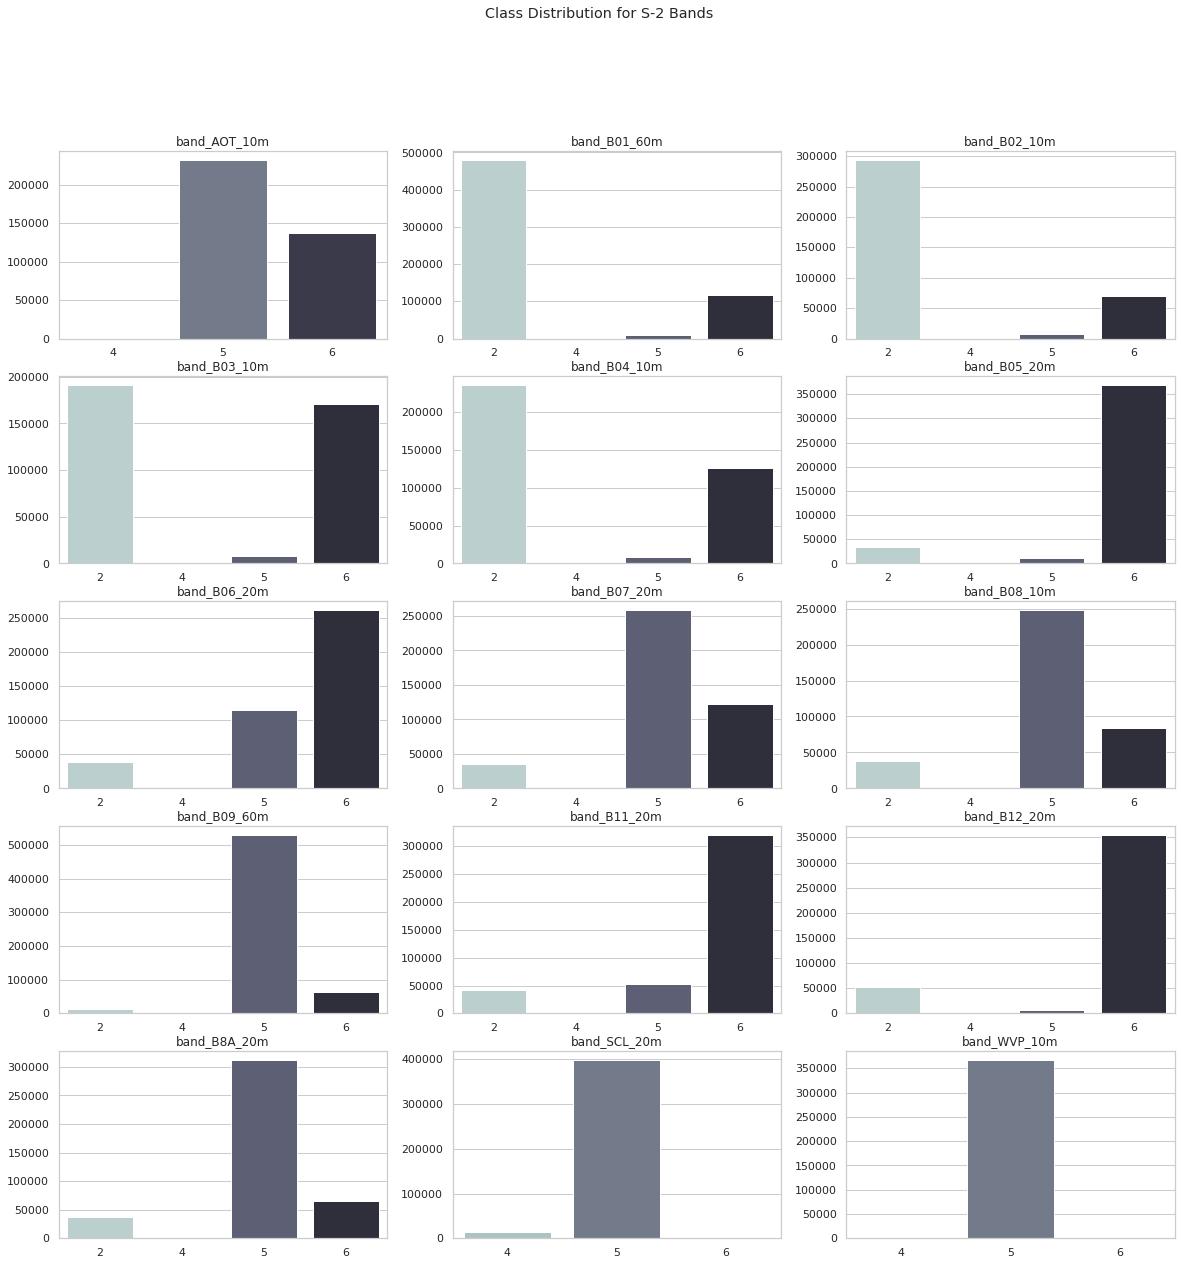

In [289]:
#Plot Class distributions for all the different bands
fig, axes = plt.subplots(5, 3, figsize=(20, 20))

fig.suptitle('Class Distribution for S-2 Bands')

sns.barplot(ax=axes[0,0], x=np.unique(band1, return_counts=True)[0], y=np.unique(band1, return_counts=True)[1], palette='bone_r').title.set_text('band_AOT_10m')
sns.barplot(ax=axes[0,1], x=np.unique(band2, return_counts=True)[0], y=np.unique(band2, return_counts=True)[1], palette='bone_r').title.set_text('band_B01_60m')
sns.barplot(ax=axes[0,2], x=np.unique(band3, return_counts=True)[0], y=np.unique(band3, return_counts=True)[1], palette='bone_r').title.set_text('band_B02_10m')
sns.barplot(ax=axes[1,0], x=np.unique(band4, return_counts=True)[0], y=np.unique(band4, return_counts=True)[1], palette='bone_r').title.set_text('band_B03_10m')
sns.barplot(ax=axes[1,1], x=np.unique(band5, return_counts=True)[0], y=np.unique(band5, return_counts=True)[1], palette='bone_r').title.set_text('band_B04_10m')
sns.barplot(ax=axes[1,2], x=np.unique(band6, return_counts=True)[0], y=np.unique(band6, return_counts=True)[1], palette='bone_r').title.set_text('band_B05_20m')
sns.barplot(ax=axes[2,0], x=np.unique(band7, return_counts=True)[0], y=np.unique(band7, return_counts=True)[1], palette='bone_r').title.set_text('band_B06_20m')
sns.barplot(ax=axes[2,1], x=np.unique(band8, return_counts=True)[0], y=np.unique(band8, return_counts=True)[1], palette='bone_r').title.set_text('band_B07_20m')
sns.barplot(ax=axes[2,2], x=np.unique(band9, return_counts=True)[0], y=np.unique(band9, return_counts=True)[1], palette='bone_r').title.set_text('band_B08_10m')
sns.barplot(ax=axes[3,0], x=np.unique(band10, return_counts=True)[0], y=np.unique(band10, return_counts=True)[1], palette='bone_r').title.set_text('band_B09_60m')
sns.barplot(ax=axes[3,1], x=np.unique(band11, return_counts=True)[0], y=np.unique(band11, return_counts=True)[1], palette='bone_r').title.set_text('band_B11_20m')
sns.barplot(ax=axes[3,2], x=np.unique(band12, return_counts=True)[0], y=np.unique(band12, return_counts=True)[1], palette='bone_r').title.set_text('band_B12_20m')
sns.barplot(ax=axes[4,0], x=np.unique(band13, return_counts=True)[0], y=np.unique(band13, return_counts=True)[1], palette='bone_r').title.set_text('band_B8A_20m')
sns.barplot(ax=axes[4,1], x=np.unique(band14, return_counts=True)[0], y=np.unique(band14, return_counts=True)[1], palette='bone_r').title.set_text('band_SCL_20m')
sns.barplot(ax=axes[4,2], x=np.unique(band15, return_counts=True)[0], y=np.unique(band15, return_counts=True)[1], palette='bone_r').title.set_text('band_WVP_10m')

In [295]:
print("band_AOT_10m : It identifies classes 5(Grassland) and 6(Water)")
print("band_B01_60m : It identifies classes 2(Forest) and 6(Water)")
print("band_B02_10m : It identifies classes 2(Forest) and 6(Water)")
print("band_B03_10m : It identifies classes 2(Forest) and 6(Water)")
print("band_B04_10m : It identifies classes 2(Forest) and 6(Water)")
print("band_B05_20m : It identifies classes 6(Water) majorly")
print("band_B06_20m : It identifies classes 5(Grassland) and 6(Water)")
print("band_B07_20m : It identifies classes 5(Grassland) and 6(Water)")
print("band_B08_10m : It identifies classes 5(Grassland) and 6(Water)")
print("band_B09_60m : It identifies classes 5(Grassland) majorly")
print("band_B11_20m : It identifies classes 6(Water) majorly")
print("band_B12_20m : It identifies classes 6(Water) majorly")
print("band_B8A_20m : It identifies classes 5(Grassland) majorly")
print("band_SCL_20m : It identifies classes 5(Grassland) majorly")
print("band_WVP_10m : It identifies classes 5(Grassland) majorly")

band_AOT_10m : It identifies classes 5(Grassland) and 6(Water)
band_B01_60m : It identifies classes 2(Forest) and 6(Water)
band_B02_10m : It identifies classes 2(Forest) and 6(Water)
band_B03_10m : It identifies classes 2(Forest) and 6(Water)
band_B04_10m : It identifies classes 2(Forest) and 6(Water)
band_B05_20m : It identifies classes 6(Water) majorly
band_B06_20m : It identifies classes 5(Grassland) and 6(Water)
band_B07_20m : It identifies classes 5(Grassland) and 6(Water)
band_B08_10m : It identifies classes 5(Grassland) and 6(Water)
band_B09_60m : It identifies classes 5(Grassland) majorly
band_B11_20m : It identifies classes 6(Water) majorly
band_B12_20m : It identifies classes 6(Water) majorly
band_B8A_20m : It identifies classes 5(Grassland) majorly
band_SCL_20m : It identifies classes 5(Grassland) majorly
band_WVP_10m : It identifies classes 5(Grassland) majorly
